# 1) Dataset

As bases de dados utilizadas são provenientes do **Banco Central do Brasil (BCB)**, mais especificamente do **Sistema Gerenciador de Séries Temporais (SGS)**.

### Fontes de dados:
- **Sistema Gerenciador de Séries Temporais (SGS/BCB):**  
  [Acessar SGS/BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries)

- **Tabela de estatísticas monetárias e de crédito**  
  (contém algumas séries administradas pelo SGS em formato `.xlsx`):  
  [Acessar estatísticas monetárias e de crédito](https://www.bcb.gov.br/estatisticas/estatisticasmonetariascredito)


## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [1]:
# ====== Imports ======
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

# Modelagem
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# ====== Funções utilitárias ======

URL_BASE = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados"

def baixar_serie_sgs(codigo: int, data_inicio: str, data_fim: str, tentativas_max: int = 5) -> pd.DataFrame:
    """
    Baixa UMA série do SGS e retorna DataFrame mensal (MS) em ['data', f'sgs_{codigo}'].
    Se a série vier diária, agrega para mensal (média).
    """
    params = {"formato": "json", "dataInicial": data_inicio, "dataFinal": data_fim}
    for tentativa in range(tentativas_max):
        try:
            resp = requests.get(
                URL_BASE.format(codigo=codigo),
                params=params,
                timeout=30,
                headers={"User-Agent": "tcc-credito/1.0"}
            )
            resp.raise_for_status()
            bruto = resp.json()
            df = pd.DataFrame(bruto)
            if df.empty:
                return pd.DataFrame(columns=["data", f"sgs_{codigo}"])

            # parse de datas: "dd/mm/aaaa" ou "mm/aaaa"
            def parse_data(s):
                for fmt in ("%d/%m/%Y", "%m/%Y"):
                    try:
                        return datetime.strptime(s, fmt)
                    except ValueError:
                        pass
                return pd.NaT

            df["data"] = df["data"].apply(parse_data)
            df[f"sgs_{codigo}"] = pd.to_numeric(df["valor"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
            df = df.dropna(subset=["data"]).set_index("data").sort_index()
            df = df[[f"sgs_{codigo}"]]
            # Detecta “múltiplas linhas por mês” (daily) e agrega; caso contrário, só reindexa
            if df.index.to_period("M").value_counts().max() > 1:
                # diária → mensal (média)
                df_m = df.resample("MS").mean()
            else:
                # já é mensal
                df_m = df.asfreq("MS")

            return df_m.reset_index()[["data", f"sgs_{codigo}"]]

        except requests.RequestException as e:
            time.sleep(2 ** tentativa)
            if tentativa == tentativas_max - 1:
                raise e

def baixar_varias_series(codigos: list[int], data_inicio: str, data_fim: str) -> pd.DataFrame:
    """Baixa e concatena por coluna (outer), com índice mensal (MS)."""
    frames = []
    for codigo in codigos:
        df = baixar_serie_sgs(codigo, data_inicio, data_fim)
        frames.append(df.set_index("data"))
    tabela = pd.concat(frames, axis=1).sort_index().asfreq("MS")
    return tabela

# Transformações
def variacao_12m_pct(serie: pd.Series, k: int = 12) -> pd.Series:
    """Variação percentual em 12 meses (YoY)."""
    return serie.pct_change(12) * 100

def adicionar_defasagens(df: pd.DataFrame, colunas: list[str], lags: list[int]) -> pd.DataFrame:
    """Cria colunas defasadas: coluna_lagK = coluna deslocada K meses para trás."""
    for c in colunas:
        for k in lags:
            df[f"{c}_lag{k}"] = df[c].shift(k)
    return df

def adicionar_alvos_futuros(df: pd.DataFrame, colunas_alvo: list[str], horizontes: list[int]) -> pd.DataFrame:
    """Cria colunas de alvo futuro: alvo_tplusH = valor H meses à frente (lead)."""
    for c in colunas_alvo:
        for h in horizontes:
            df[f"{c}_tplus{h}"] = df[c].shift(-h)
    return df

# --- Imports compatíveis com versões 1.0–1.x do scikit-learn ---
try:
    from sklearn.metrics import root_mean_squared_error as _rmse_metric  # >= 1.4
except ImportError:  # versões mais antigas
    from sklearn.metrics import mean_squared_error as _mse_metric
    def _rmse_metric(y_true, y_pred):
        # fallback sem o parâmetro deprecated no seu código
        return _mse_metric(y_true, y_pred, squared=False)

def rmse_score(y_true, y_pred):
    """
    RMSE com alinhamento inteligente:
    - Se ambos forem Series com DatetimeIndex, alinha por interseção do índice.
    - Caso contrário (arrays ou RangeIndex), compara posição a posição.
    """
    # Caso 1: ambos Series com DatetimeIndex
    if isinstance(y_true, pd.Series) and isinstance(y_pred, pd.Series) \
       and isinstance(y_true.index, pd.DatetimeIndex) and isinstance(y_pred.index, pd.DatetimeIndex):
        idx = y_true.index.intersection(y_pred.index)
        yt = pd.to_numeric(y_true.loc[idx], errors="coerce")
        yp = pd.to_numeric(y_pred.loc[idx], errors="coerce")
        return float(_rmse_metric(yt, yp))

    # Caso 2: fallback posicional
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    minlen = min(len(yt), len(yp))
    return float(_rmse_metric(yt[:minlen], yp[:minlen]))

## Coletando as séries do Sistema Gerenciador de Séries Temporais / BCB

In [3]:
# ====== Séries e datas ======
CODIGOS = {
    # Estoques (nível)
    "saldo_total": 20539,
    "saldo_pj":    20540,
    "saldo_pf":    20541,
    # Inadimplência (% carteira, >=90 dias)
    "inad_total":  21082,
    "inad_pj":     21083,
    "inad_pf":     21084,
    # Taxas médias (novas operações, % a.a. do mês)
    "taxa_total":  20714,
    "taxa_pj":     20715,  # (não vamos usar em PF t+3; mantido só para eventual consulta)
    "taxa_pf":     20716,  # (idem)
    # Política monetária
    "selic_432":   432,   # Meta da Selic
}

DATA_INICIO = "01/01/2021"
DATA_FIM    = datetime.today().strftime("%d/%m/%Y")

In [4]:
todos = list(CODIGOS.values())
bruto = baixar_varias_series(todos, DATA_INICIO, DATA_FIM)

# Renomear colunas sgs_XXXX -> nomes amigáveis
mapa = {f"sgs_{v}": k for k, v in CODIGOS.items()}
dados = bruto.rename(columns=mapa).copy()

# Preencher buracos pontuais 
cols_exog = ["selic_432", "taxa_pf", "taxa_total", "saldo_total", "saldo_pf", "saldo_pj"]
dados[cols_exog] = dados[cols_exog].ffill(limit=1)

# ===== Transformações principais =====
dados["saldo_total_var12m"] = variacao_12m_pct(dados["saldo_total"])
dados["saldo_pf_var12m"]    = variacao_12m_pct(dados["saldo_pf"])
dados["saldo_pj_var12m"]    = variacao_12m_pct(dados["saldo_pj"])

# ===== Defasagens (PF t+3: lags CURTOS e sem 0-lag) =====
# Juros / preço do crédito (fortes em 1–3m para PF em testes anteriores)
dados = adicionar_defasagens(dados, ["selic_432"], lags=[1, 3])
dados = adicionar_defasagens(dados, ["taxa_pf"], lags=[1, 3])
dados = adicionar_defasagens(dados, ["saldo_pf_var12m", "saldo_pj_var12m"], lags=[1, 3])

# ===== Alvo no futuro (APENAS t+3 e APENAS PF) =====
dados = adicionar_alvos_futuros(dados, ["inad_pf"], horizontes=[3])
if "inad_pf_t+3" in dados.columns:
    dados = dados.rename(columns={"inad_pf_t+3": "inad_pf_tplus3"}) 


dados.to_csv("base_sgs.csv", index=True, index_label="data")
dados

/tmp/ipykernel_50824/2297637728.py:65: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return serie.pct_change(12) * 100
/tmp/ipykernel_50824/2297637728.py:65: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return serie.pct_change(12) * 100
/tmp/ipykernel_50824/2297637728.py:65: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return serie.pct_change(12) * 100


,saldo_total,saldo_pj,saldo_pf,inad_total,inad_pj,inad_pf,taxa_total,taxa_pj,taxa_pf,selic_432,...,saldo_pj_var12m,selic_432_lag1,selic_432_lag3,taxa_pf_lag1,taxa_pf_lag3,saldo_pf_var12m_lag1,saldo_pf_var12m_lag3,saldo_pj_var12m_lag1,saldo_pj_var12m_lag3,inad_pf_tplus3
data,,,,,,,,,,,,,,,,,,,,,
2021-01-01,4017481.0,1764350.0,2253131.0,2.14,1.20,2.88,19.90,13.63,23.80,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.91
2021-02-01,4044845.0,1774313.0,2270532.0,2.23,1.35,2.92,19.62,12.32,24.16,2.000000,...,NaN,2.000000,NaN,23.80,NaN,NaN,NaN,NaN,NaN,2.97
2021-03-01,4106449.0,1809384.0,2297064.0,2.13,1.20,2.87,19.79,12.31,24.48,2.338710,...,NaN,2.000000,NaN,24.16,NaN,NaN,NaN,NaN,NaN,2.87
2021-04-01,4126914.0,1804880.0,2322034.0,2.19,1.27,2.91,20.26,13.04,24.75,2.750000,...,NaN,2.338710,2.000000,24.48,23.80,NaN,NaN,NaN,NaN,2.90
2021-05-01,4175472.0,1814790.0,2360682.0,2.33,1.51,2.97,19.79,12.75,24.11,3.379032,...,NaN,2.750000,2.000000,24.75,24.16,NaN,NaN,NaN,NaN,2.92
2021-06-01,4212400.0,1814263.0,2398138.0,2.27,1.48,2.87,19.92,12.93,24.18,3.850000,...,NaN,3.379032,2.338710,24.11,24.48,NaN,NaN,NaN,NaN,2.97
2021-07-01,4269669.0,1830524.0,2439145.0,2.31,1.52,2.90,20.30,13.87,24.15,4.250000,...,NaN,3.850000,2.750000,24.18,24.75,NaN,NaN,NaN,NaN,2.95
2021-08-01,4344165.0,1848208.0,2495958.0,2.31,1.50,2.92,20.97,14.67,24.68,5.120968,...,NaN,4.250000,3.379032,24.15,24.11,NaN,NaN,NaN,NaN,2.97
2021-09-01,4439121.0,1891192.0,2547929.0,2.28,1.36,2.97,21.46,15.11,25.24,5.516667,...,NaN,5.120968,3.850000,24.68,24.18,NaN,NaN,NaN,NaN,3.00


# 2) EDA (Exploratory Data Analysis)

## 1. Definição
**EDA – Análise Exploratória de Dados** é a etapa inicial de um projeto de ciência de dados.  
Ela serve para **entender, limpar e organizar os dados** antes de aplicar modelos estatísticos ou de machine learning.  

👉 Em termos simples: é como "investigar" seus dados para descobrir padrões, erros, outliers (valores muito fora do normal) e relações entre variáveis.

## 2. Objetivos deste EDA
1. **Conhecer os dados**: período, amostra, valores faltantes e estatísticas básicas.
2. **Visualizar séries**: inadimplência PF/PJ, crescimento do saldo, Selic e taxas.
3. **Ver correlações com defasagens** (0, 1, 3, 6, 12) entre as explicativas e as metas (inad_pf e inad_pj).
4. **Checar estacionaridade** (ADF) e **olhar ACF/PACF** das metas.




In [5]:
# --- Recorte temporal a partir de 2022 ---
INICIO_ANALISE = pd.Timestamp("2022-01-01")  # para EDA
dados_analise = dados.loc[dados.index >= INICIO_ANALISE].copy()

# 1) Panorama geral (a partir de 2022)
print("Formato:", dados_analise.shape)
print("Período:", dados_analise.index.min().date(), "→", dados_analise.index.max().date())

faltantes = dados_analise.isna().sum().sort_values(ascending=False)
print("\nTop 20 variáveis com faltantes:")
print(faltantes.head(20))

print("\nEstatísticas básicas das principais variáveis:")
cols_stats = ["inad_pf","inad_pj","saldo_total_var12m","selic_432","taxa_total","taxa_pf","taxa_pj"]
cols_stats = [c for c in cols_stats if c in dados_analise.columns]
print(dados_analise[cols_stats].describe().T)


Formato: (46, 22)
Período: 2022-01-01 → 2025-10-01

Top 20 variáveis com faltantes:
inad_pf_tplus3          5
saldo_pf_var12m_lag3    3
saldo_pj_var12m_lag3    3
inad_pf                 2
inad_pj                 2
inad_total              2
taxa_pj                 2
saldo_pf                1
saldo_total             1
saldo_pj                1
saldo_pf_var12m_lag1    1
taxa_total              1
taxa_pf                 1
saldo_pj_var12m_lag1    1
selic_432_lag1          0
saldo_pj_var12m         0
saldo_pf_var12m         0
saldo_total_var12m      0
selic_432               0
taxa_pf_lag3            0
dtype: int64

Estatísticas básicas das principais variáveis:
                    count       mean       std        min        25%  \
inad_pf              44.0   3.839318  0.310524   3.210000   3.660000   
inad_pj              44.0   2.174318  0.451372   1.360000   1.697500   
saldo_total_var12m   46.0  12.007467  3.064172   7.692153   9.546731   
selic_432            46.0  12.701352  1.542046 

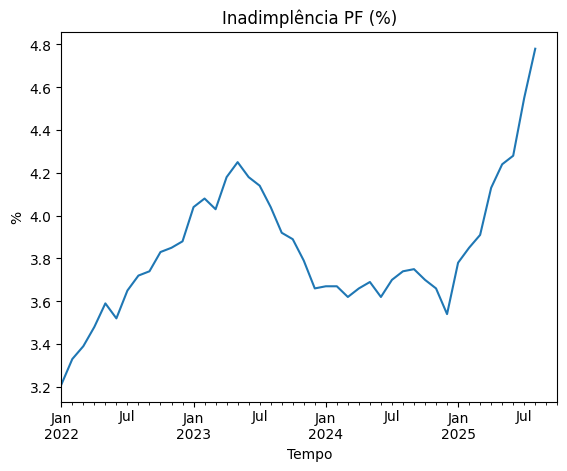

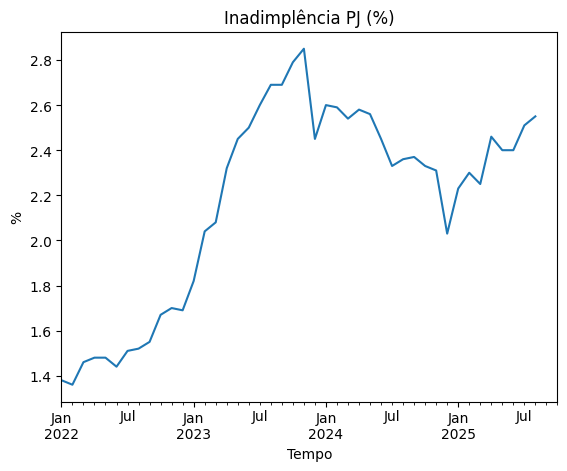

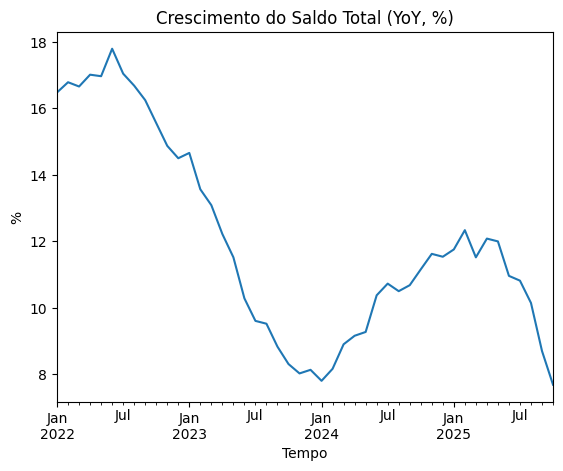

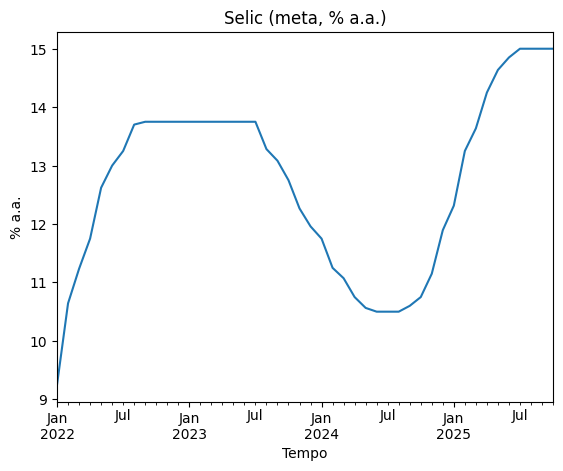

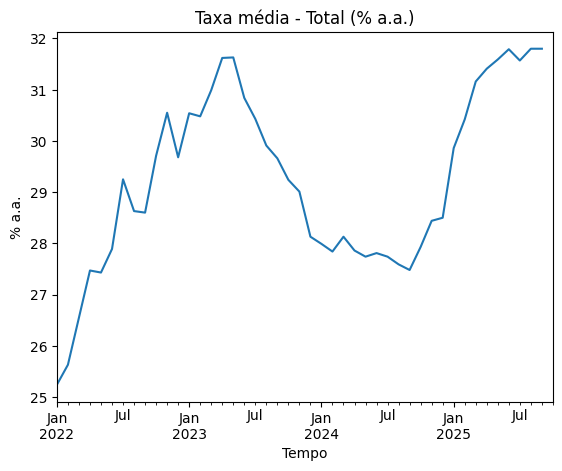

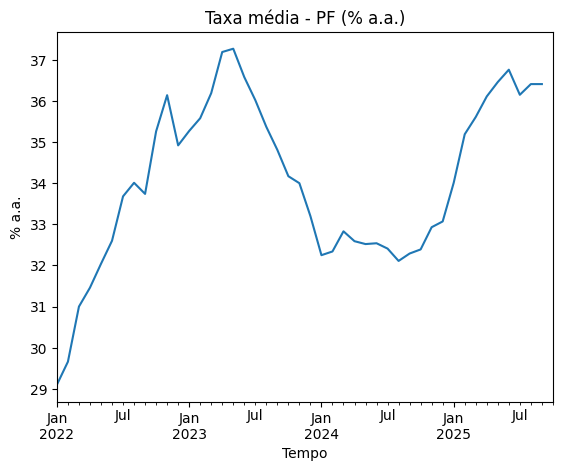

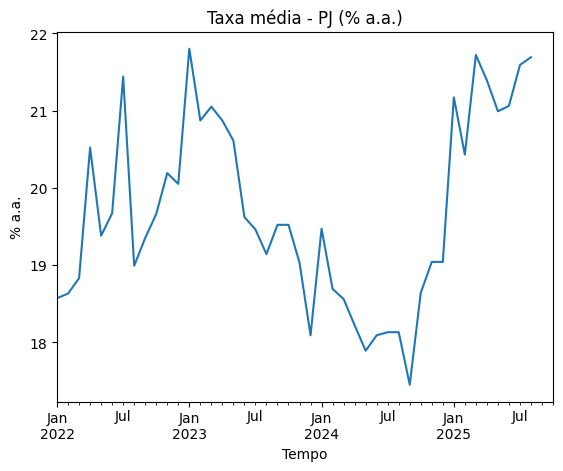

In [6]:
# 2) Visualizações (um gráfico por figura, sem estilos/cor específicos)
import matplotlib.pyplot as plt

base_plot = dados_analise.copy()

def plota(df, col, titulo, ylabel):
    if col in df.columns:
        plt.figure()
        df[col].plot(title=titulo)
        plt.xlabel("Tempo"); plt.ylabel(ylabel)
        plt.show()

plota(base_plot, "inad_pf", "Inadimplência PF (%)", "%")
plota(base_plot, "inad_pj", "Inadimplência PJ (%)", "%")

plota(base_plot, "saldo_total_var12m", "Crescimento do Saldo Total (YoY, %)", "%")

plota(base_plot, "selic_432", "Selic (meta, % a.a.)", "% a.a.")
plota(base_plot, "taxa_total", "Taxa média - Total (% a.a.)", "% a.a.")
plota(base_plot, "taxa_pf", "Taxa média - PF (% a.a.)", "% a.a.")
plota(base_plot, "taxa_pj", "Taxa média - PJ (% a.a.)", "% a.a.")

Checagem rápida de correlação entre o alvo t+3 e lags das exógenas (correlação cruzada — quão associado está hoje com o que aconteceu meses atrás):

In [7]:
if 'inad_pf_tplus3' in dados_analise.columns:
    candidatos = [c for c in dados_analise.columns if c.endswith(('_lag1','_lag3','_lag6','_lag12'))]
    corr = {c: dados_analise['inad_pf_tplus3'].corr(dados_analise[c]) for c in candidatos}
    print(pd.Series(corr).dropna().sort_values(ascending=False).head(15))


selic_432_lag1          0.656207
taxa_pf_lag1            0.634588
saldo_pj_var12m_lag3    0.616559
selic_432_lag3          0.456760
taxa_pf_lag3            0.410619
saldo_pj_var12m_lag1    0.409866
saldo_pf_var12m_lag3    0.169931
saldo_pf_var12m_lag1    0.050581
dtype: float64


In [8]:
# 3) Correlações com defasagens — quais atrasos explicam melhor inad_pf?
if 'inad_pf_tplus3' not in base_plot.columns and 'inad_pf' in base_plot.columns:
    base_plot['inad_pf_tplus3'] = base_plot['inad_pf'].shift(-3)

from IPython.display import display, HTML
def display_dataframe_to_user(titulo: str, dataframe: pd.DataFrame):
    display(HTML(f"<h3>{titulo}</h3>"))
    display(dataframe)

def correlacao_com_lag(alvo: pd.Series, explicativa: pd.Series, lags=(1,3,6,12)):
    return {k: alvo.corr(explicativa.shift(k)) for k in lags}

# Base de explicativas com foco em PF
explicativas_pf = {
    "selic_432": base_plot["selic_432"],                 # meta Selic (mensal)
    "taxa_pf": base_plot["taxa_pf"],                     # preço do crédito PF
    "spread_pf": base_plot["taxa_pf"] - base_plot["selic_432"],  # diferencial de preço (p.p.)
    "saldo_pf_var12m": base_plot["saldo_pf_var12m"],     # ciclo de carteira PF (YoY, %)
}

linhas = []
for nome, serie in explicativas_pf.items():
    corr_pf_t3 = correlacao_com_lag(base_plot["inad_pf_tplus3"], serie, lags=(1,3,6,12))
    for k in [1,3,6,12]:
        linhas.append({
            "variavel": nome,
            "lag": k,
            "corr_inad_pf_tplus3": corr_pf_t3[k]
        })

tabela_corr_pf = (
    pd.DataFrame(linhas)
      .dropna(subset=["corr_inad_pf_tplus3"])
      .sort_values("corr_inad_pf_tplus3", key=lambda s: s.abs(), ascending=False)
)

display_dataframe_to_user("Correlação (|ρ|) com inad_pf_tplus3", tabela_corr_pf)

,variavel,lag,corr_inad_pf_tplus3
3,selic_432,12,-0.865698
7,taxa_pf,12,-0.717100
0,selic_432,1,0.633272
4,taxa_pf,1,0.610534
11,spread_pf,12,-0.325132
1,selic_432,3,0.323667
8,spread_pf,1,0.308525
6,taxa_pf,6,-0.291689
5,taxa_pf,3,0.255754
10,spread_pf,6,-0.254732


Teste ADF do alvo que será modelado (PF t+3):
inad_pf_tplus3 (nível): ADF=-1.142, p-valor=0.6980, lags_usados=3, n_obs=37
taxa_pf (nível): ADF=-2.479, p-valor=0.1208, lags_usados=3, n_obs=41
taxa_pf.diff(1) (Δ p.p.): ADF=-4.318, p-valor=0.0004, lags_usados=0, n_obs=43
selic_432 (nível): ADF=-4.270, p-valor=0.0005, lags_usados=3, n_obs=42
selic_432.diff(1) (Δ p.p.): ADF=-2.332, p-valor=0.1619, lags_usados=3, n_obs=41
Lags usados — inad_pf_tplus3: ACF=24, PACF=19


<Figure size 640x480 with 0 Axes>

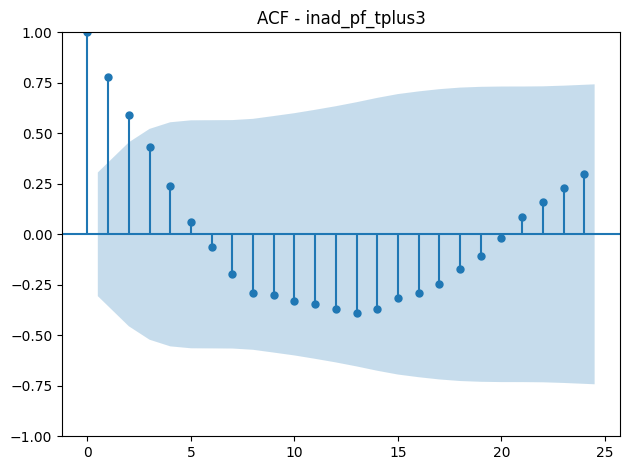

<Figure size 640x480 with 0 Axes>

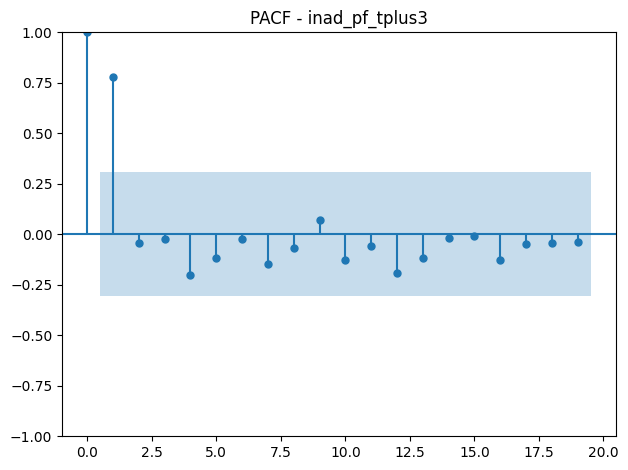

In [9]:
# 4) Teste ADF (estacionaridade) e ACF/PACF

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

def resumo_adf(serie, nome):
    serie_clean = pd.to_numeric(pd.Series(serie), errors="coerce").dropna()
    if len(serie_clean) < 25:
        print(f"{nome}: série muito curta para ADF (n={len(serie_clean)})")
        return
    res = adfuller(serie_clean, autolag='AIC')
    print(f"{nome}: ADF={res[0]:.3f}, p-valor={res[1]:.4f}, lags_usados={res[2]}, n_obs={res[3]}")

def lags_acf_max(serie, desejado=24):
    n = pd.to_numeric(pd.Series(serie), errors="coerce").dropna().shape[0]
    # ACF pode ir até n-2; usamos um bound seguro
    return max(1, min(desejado, n - 2))

def lags_pacf_max(serie, desejado=24):
    n = pd.to_numeric(pd.Series(serie), errors="coerce").dropna().shape[0]
    # PACF exige nlags < n/2 -> usar (n//2 - 1) como limite superior
    return max(1, min(desejado, (n // 2) - 1))
# garantir o alvo t+3 no EDA
if 'inad_pf_tplus3' not in base_plot and 'inad_pf' in base_plot:
    base_plot['inad_pf_tplus3'] = base_plot['inad_pf'].shift(-3)

print("Teste ADF do alvo que será modelado (PF t+3):")
resumo_adf(base_plot["inad_pf_tplus3"], "inad_pf_tplus3 (nível)")

# Teste ADF nas EXÓGENAS (nível e 1a diferença em p.p.)
for nome in ["taxa_pf", "selic_432"]:
    if nome in base_plot:
        resumo_adf(base_plot[nome], f"{nome} (nível)")
        resumo_adf(base_plot[nome].diff(), f"{nome}.diff(1) (Δ p.p.)")

# ACF/PACF do alvo (use a versão estacionária se ADF indicar não-estacionária)
serie_alvo = pd.to_numeric(base_plot["inad_pf_tplus3"], errors="coerce").dropna()
lags_alvo_acf  = lags_acf_max(serie_alvo, 24)
lags_alvo_pacf = lags_pacf_max(serie_alvo, 24)

print(f"Lags usados — inad_pf_tplus3: ACF={lags_alvo_acf}, PACF={lags_alvo_pacf}")
plt.figure(); plot_acf(serie_alvo, lags=lags_alvo_acf); plt.title("ACF - inad_pf_tplus3"); plt.tight_layout(); plt.show()
plt.figure()
try:
    plot_pacf(serie_alvo, lags=lags_alvo_pacf, method="ywm")
except TypeError:
    plot_pacf(serie_alvo, lags=lags_alvo_pacf, method="yw")
plt.title("PACF - inad_pf_tplus3"); plt.tight_layout(); plt.show()


# 3) Modelos Tradicionais

In [10]:
# ==== ARIMAX (SARIMAX) para inad_pf t+3 (modelo direto) ====
H = 3
INICIO_TREINO = pd.Timestamp("2022-04-01")  # evita que lag1/lag3 alcancem 2021

# Garantia de ordem/frequência mensal (segurança)
base_plot = base_plot.sort_index().asfreq("MS")

# Alvo
base_plot["inad_pf_tplus3"] = base_plot["inad_pf"].shift(-H)

# Exógenas coerentes com EDA:
# - Selic em nível (ADF estacionária nessa janela)
# - Δtaxa_pf em p.p. (ADF estacionária) + lags
base_plot["taxa_pf_d1"]   = base_plot["taxa_pf"].diff(1)                          # Δ p.p.
base_plot["spread_pf_d1"] = (base_plot["taxa_pf"] - base_plot["selic_432"]).diff(1)  # (criada, mas fora das FEATURES)

# Criar lags necessários
for col, lags in {
    "selic_432":     [1, 3, 12],   # nível
    "taxa_pf_d1":    [1, 3, 12],   # Δ p.p.
    "spread_pf_d1":  [1, 3, 12],   # Δ p.p. (opcional)
}.items():
    for L in lags:
        base_plot[f"{col}_lag{L}"] = base_plot[col].shift(L)

# Features parcimoniosas (PF t+3) — mesmas que você estava usando
FEATURES = [
    "selic_432_lag1", "selic_432_lag3",
    "taxa_pf_d1_lag1", "taxa_pf_d1_lag3",
    # "selic_432_lag12",      # <- opcional: ative 1 lag12 por vez se quiser testar efeito anual
    # "taxa_pf_d1_lag12",     # <- opcional (não use ambos 12's ao mesmo tempo na amostra curta)
]
FEATURES = [c for c in FEATURES if c in base_plot.columns]
TARGET = "inad_pf_tplus3"

# Dataset limpo, MESMA AMOSTRA para todas as métricas + recorte temporal
df_model = base_plot[[TARGET] + FEATURES].loc[INICIO_TREINO:].dropna()
y = df_model[TARGET]
X = df_model[FEATURES]

# Split temporal 70/30 (sem shuffle)
n = len(df_model); n_tr = int(n * 0.7)
y_train, y_test = y.iloc[:n_tr], y.iloc[n_tr:]
X_train, X_test = X.iloc[:n_tr], X.iloc[n_tr:]

# 1) alinhar colunas do teste (mesma ordem do treino)
X_test = X_test.reindex(columns=X_train.columns)

# 2) garantir numérico
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

# 3) padronizar com estatísticas do TREINO (ajuda a convergência)
mu = X_train.mean()
sd = X_train.std(ddof=0).replace(0, 1.0)  # evita divisão por zero
X_train = (X_train - mu) / sd
X_test  = (X_test  - mu) / sd

# SARIMAX: endog é o alvo deslocado (modelo direto para H passos)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

def fit(order, method="lbfgs"):
    m = SARIMAX(
        y_train, exog=X_train,
        order=order, seasonal_order=(0,0,0,0),
        trend="c",                      # constante (corrige viés de nível)
        enforce_stationarity=False, enforce_invertibility=False
        # , simple_differencing=True     # <- opcional: pode ajudar em amostra curta
    )
    return m.fit(method=method, maxiter=2000, disp=False)

cands = [(1,1,0),(0,1,1),(1,1,1),(2,1,1)]
res_list = []
for o in cands:
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res_list.append((o, fit(o, method="lbfgs")))
    except Exception:
        res_list.append((o, fit(o, method="powell")))   # fallback robusto

def aicc(res):
    k = res.params.size; nobs = res.nobs
    return res.aic + (2*k*(k+1)) / max(nobs - k - 1, 1)

best_order, best_res = sorted(res_list, key=lambda t: aicc(t[1]))[0]
print("Best order:", best_order, "AICc≈", round(aicc(best_res), 2))

# Previsão coerente com o nº de linhas do teste
X_test_aligned = X_test.reindex(columns=X_train.columns)
assert X_test_aligned.shape[1] == best_res.model.k_exog, "Qtd de exógenas no teste ≠ treino"
assert len(y_test) == len(X_test_aligned), "Nº de linhas em X_test ≠ y_test"

pred_obj    = best_res.get_forecast(steps=len(y_test), exog=X_test_aligned)
y_pred_test = pred_obj.predicted_mean

# Avaliação
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = rmse_score(y_test, y_pred_test)
lb   = acorr_ljungbox(best_res.resid, lags=[12], return_df=True)

print({"MAE": mae, "RMSE": rmse, "LjungBox_p": float(lb["lb_pvalue"].iloc[0])})


Best order: (0, 1, 1) AICc≈ -43.69
{'MAE': 0.28581475820449037, 'RMSE': 0.37426501933708084, 'LjungBox_p': 0.9999999979672467}


In [11]:
# ====== Salvar dataset pronto e resultados ======
Path("dados").mkdir(exist_ok=True)

# Parquet (inclui índice) — opcional: compressão snappy
dados.to_parquet("dados/base_tcc.parquet", engine="pyarrow", compression="snappy", index=True)

# CSV com rótulo do índice para facilitar reimportação
dados.to_csv("dados/base_tcc.csv", index=True, index_label="data")

print("Arquivos salvos em 'dados/':")
for f in ["dados/base_tcc.parquet", "dados/base_tcc.csv"]:
    print(" -", f)


Arquivos salvos em 'dados/':
 - dados/base_tcc.parquet
 - dados/base_tcc.csv


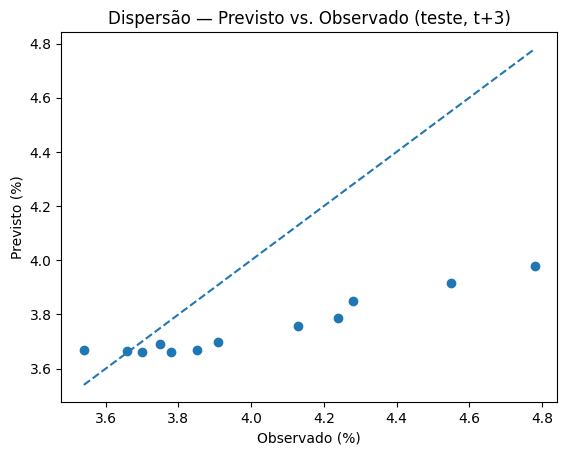

In [12]:
# ====== GRÁFICOS E AVALIAÇÃO (teste) ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Alinha por índice e remove NaN pareados
y_obs, y_pred = y_test.align(y_pred_test, join="inner")
mask = ~(y_obs.isna() | y_pred.isna())
y_obs = y_obs[mask]
y_pred = y_pred[mask]

# 3) Dispersão Previsto × Observado (teste)
plt.figure()
plt.scatter(y_obs, y_pred)
plt.title("Dispersão — Previsto vs. Observado (teste, t+3)")
plt.xlabel("Observado (%)"); plt.ylabel("Previsto (%)")

mn = np.nanmin([y_obs.min(), y_pred.min()])
mx = np.nanmax([y_obs.max(), y_pred.max()])
plt.plot([mn, mx], [mn, mx], linestyle="--")  # 45°
plt.show()

In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Métricas e regressão Previsto ~ Observado
residuos = (y_obs - y_pred)
m, b = np.polyfit(y_obs, y_pred, 1)  # inclinação/intercepto

print({
    "MAE":  float(mean_absolute_error(y_obs, y_pred)),
    "RMSE": float(rmse_score(y_obs, y_pred)),
    "R2_teste": float(r2_score(y_obs, y_pred)),
    "Viés_médio (obs - prev)": float(residuos.mean()),
    "Inclinação_prev~obs": float(m),  # ideal ≈ 1
    "Intercepto": float(b)            # ideal ≈ 0
})


{'MAE': 0.28581475820449037, 'RMSE': 0.37426501933708084, 'R2_teste': -0.03752873431603709, 'Viés_médio (obs - prev)': 0.26360988722712725, 'Inclinação_prev~obs': 0.280252010822823, 'Intercepto': 2.6255784993282583}


In [14]:
# ====== Features usadas e export dos resultados (t+3) ======
from pathlib import Path
import pandas as pd

if 'X_test' in globals() and 'y_test' in globals():
    # Lista de features
    try:
        print("Nº de features (treino):", X_train.shape[1])
    except Exception:
        pass
    print("Nº de features (teste):", X_test.shape[1])
    print("Features usadas (primeiras 30):", list(X_test.columns)[:30])

    # Gera previsões se ainda não existirem (usa o melhor modelo)
    if 'y_pred_test' not in globals():
        try:
            # garante MESMA ordem de colunas do treino
            X_test_aligned = X_test.reindex(columns=X_train.columns)
            # mesmo nº de passos do teste
            y_pred_test = best_res.get_forecast(steps=len(y_test), exog=X_test_aligned).predicted_mean
        except Exception as e:
            print("Não foi possível gerar y_pred_test automaticamente:", e)

    if 'y_pred_test' in globals():
        # Alinha observados e previstos por segurança
        obs, prev = y_test.align(y_pred_test, join="inner")
        resultado_teste = pd.DataFrame({"observado": obs, "previsto": prev})

        Path("resultados").mkdir(exist_ok=True)
        out_csv = "resultados/observado_previsto_inad_pf_tplus3.csv"  # evita '+' no nome
        resultado_teste.to_csv(out_csv, index=True, index_label="data")
        print("Arquivo salvo:", out_csv)

        try:
            display(resultado_teste.tail())
        except Exception:
            print("Prévia (tail):")
            print(resultado_teste.tail())
    else:
        print("Defina y_pred_test antes de rodar esta célula.")
else:
    print("Defina X_test e y_test antes de rodar esta célula.")



Nº de features (treino): 4
Nº de features (teste): 4
Features usadas (primeiras 30): ['selic_432_lag1', 'selic_432_lag3', 'taxa_pf_d1_lag1', 'taxa_pf_d1_lag3']
Arquivo salvo: resultados/observado_previsto_inad_pf_tplus3.csv


,observado,previsto
2025-01-01,4.13,3.758975
2025-02-01,4.24,3.786117
2025-03-01,4.28,3.849934
2025-04-01,4.55,3.917781
2025-05-01,4.78,3.980346


# 4) Modelos de machine learning

## XGBoost

In [15]:
%pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
# ==== XGBoost: treino simples, sem early stopping (compatível com qualquer versão) ====
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Garantir features (como você já montou)
FEATS = ["selic_432_lag1","selic_432_lag3","taxa_pf_d1_lag1","taxa_pf_d1_lag3","inad_pf_lag1"]
if "inad_pf_lag1" not in base_plot:
    base_plot["inad_pf_lag1"] = base_plot["inad_pf"].shift(1)

df_ml = base_plot[["inad_pf_tplus3"] + FEATS].dropna()
y = df_ml["inad_pf_tplus3"].astype(float)
X = df_ml[FEATS].astype(float)

# Split temporal 70/30
n = len(df_ml); n_tr = int(n*0.7)
X_tr, X_te = X.iloc[:n_tr], X.iloc[n_tr:]
y_tr, y_te = y.iloc[:n_tr], y.iloc[n_tr:]

# Pipeline (scaler não é essencial para árvores, mas não atrapalha)
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=5.0, reg_alpha=0.0, min_child_weight=2,
        random_state=42, n_jobs=1, verbosity=0, tree_method="hist"
    ))
])

pipe.fit(X_tr, y_tr)
y_pred = pipe.predict(X_te)

rmse = lambda a,b: float(np.sqrt(((np.asarray(a)-np.asarray(b))**2).mean()))
print({"MAE_XGB": float(mean_absolute_error(y_te, y_pred)),
       "RMSE_XGB": rmse(y_te, y_pred)})


{'MAE_XGB': 0.2873825899759929, 'RMSE_XGB': 0.37107725855102486}


## SVR

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

pipe_svr = Pipeline([
    ("sc", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

# grid pequeno (amostra curta!)
grids = [
    {"svr__C": [3, 10], "svr__epsilon": [0.05, 0.1], "svr__gamma": ["scale", 0.1]}
]

# simples "manual search" temporal
tscv = TimeSeriesSplit(n_splits=4)
best_mae, best_params = 1e9, None
for g in grids:
    for C in g["svr__C"]:
        for eps in g["svr__epsilon"]:
            for gam in g["svr__gamma"]:
                maes=[]
                for tr_idx, va_idx in tscv.split(X_tr):
                    X_tr_i, X_va_i = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
                    y_tr_i, y_va_i = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]
                    m = Pipeline([("sc", StandardScaler()), ("svr", SVR(kernel="rbf", C=C, epsilon=eps, gamma=gam))])
                    m.fit(X_tr_i, y_tr_i)
                    maes.append(mean_absolute_error(y_va_i, m.predict(X_va_i)))
                m_mae = float(np.mean(maes))
                if m_mae < best_mae:
                    best_mae, best_params = m_mae, {"C":C,"epsilon":eps,"gamma":gam}

# treina final com melhores params e avalia no teste
pipe_svr = Pipeline([("sc", StandardScaler()), ("svr", SVR(kernel="rbf", **best_params))])
pipe_svr.fit(X_tr, y_tr)
y_pred_svr = pipe_svr.predict(X_te)
print({"best_params_svr": best_params,
       "MAE_SVR": float(mean_absolute_error(y_te, y_pred_svr)),
       "RMSE_SVR": float(rmse_score(y_te, y_pred_svr))})


{'best_params_svr': {'C': 10, 'epsilon': 0.05, 'gamma': 0.1}, 'MAE_SVR': 0.26197536689663486, 'RMSE_SVR': 0.3355032073216211}


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

# 1) features (ex.: as mesmas do ARIMAX + 1 lag do alvo para ML)
FEATS = ["selic_432_lag1","selic_432_lag3","taxa_pf_d1_lag1","taxa_pf_d1_lag3","inad_pf_lag1"]
df_ml = base_plot[["inad_pf_tplus3"] + FEATS].dropna()
y = df_ml["inad_pf_tplus3"].astype(float)
X = df_ml[FEATS].astype(float)

# 2) split temporal 70/30
n = len(df_ml); n_tr = int(n*0.7)
X_tr, X_te = X.iloc[:n_tr], X.iloc[n_tr:]
y_tr, y_te = y.iloc[:n_tr], y.iloc[n_tr:]

# 3) TREINAR: escolha 1 modelo (SVR ou XGB)

## (a) SVR
from sklearn.svm import SVR
svr = Pipeline([("sc", StandardScaler()), ("m", SVR(kernel="rbf", C=10, epsilon=0.1))])
svr.fit(X_tr, y_tr)
y_pred_svr = svr.predict(X_te)

## (b) XGBoost
from xgboost import XGBRegressor
xgb = Pipeline([("sc", StandardScaler()),
                ("m", XGBRegressor(n_estimators=500, learning_rate=0.05,
                                   max_depth=3, subsample=0.8, colsample_bytree=0.8,
                                   reg_lambda=5.0, random_state=42))]
               )
xgb.fit(X_tr, y_tr)
y_pred_xgb = xgb.predict(X_te)

# 4) MÉTRICAS (depois de prever)
def rmse(a, b): return float(np.sqrt(((np.array(a)-np.array(b))**2).mean()))
print({"SVR_MAE": float(mean_absolute_error(y_te, y_pred_svr)), "SVR_RMSE": rmse(y_te, y_pred_svr)})
print({"XGB_MAE": float(mean_absolute_error(y_te, y_pred_xgb)), "XGB_RMSE": rmse(y_te, y_pred_xgb)})


{'SVR_MAE': 0.2608368198734126, 'SVR_RMSE': 0.325594685833084}
{'XGB_MAE': 0.27850266456604006, 'XGB_RMSE': 0.3672767826483159}


,MAE,RMSE,R2,Bias (obs - prev),Slope pred~obs,Intercept
ARIMAX,0.285815,0.374265,-0.037529,0.263610,0.280252,2.625578
XGB,0.287383,0.371077,-0.019930,0.268090,0.323421,2.447811
SVR,0.260837,0.325595,0.214771,0.140552,0.213755,3.015568
Ensemble (0.7 SVR + 0.3 ARIMAX),0.257461,0.335585,0.165846,0.177469,0.233704,2.898571


Arquivo de métricas salvo em: resultados/comparativo_metricas.csv
Arquivo de séries salvo em: resultados/comparativo_previstos.csv


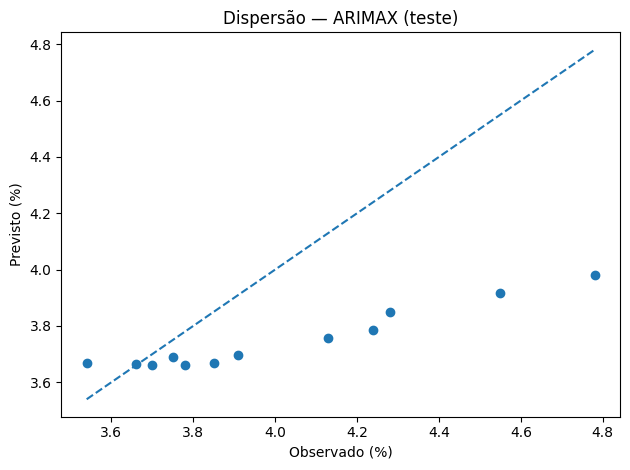

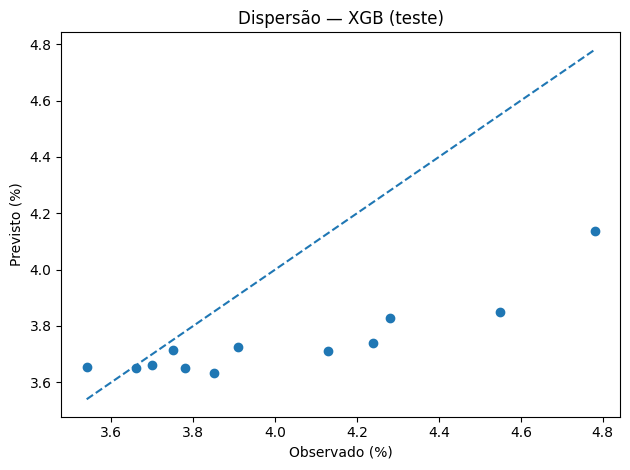

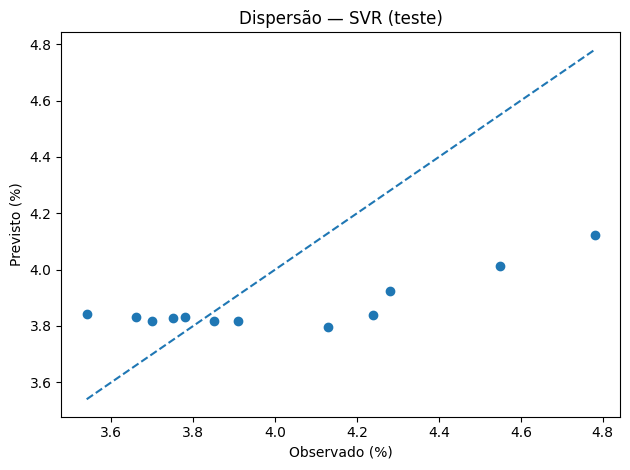

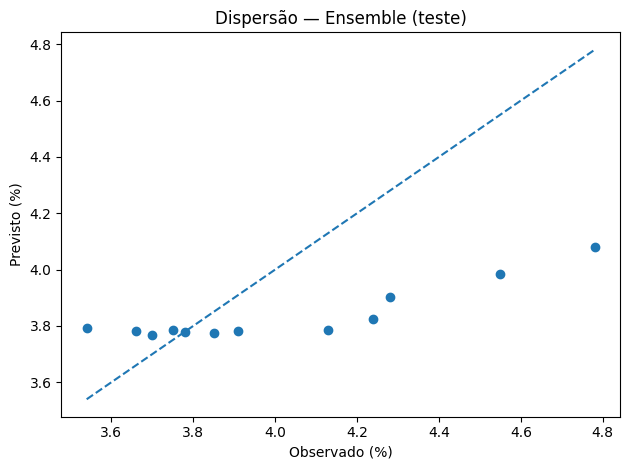

In [26]:
# ====== Comparativo de modelos + Ensemble (plug-and-play) ======
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, r2_score

# --- helper RMSE: usa sua rmse_score se existir, senão define local ---
def _rmse(a, b):
    try:
        return float(rmse_score(pd.Series(a), pd.Series(b)))
    except Exception:
        a = np.asarray(a, float); b = np.asarray(b, float)
        return float(np.sqrt(((a - b) ** 2).mean()))

# --- alinhamento robusto: tenta por índice; se não der, cai para posicional ---
def _align(obs, pred):
    obs = pd.Series(obs, dtype=float)
    # vira Series com mesmo índice do obs quando vier array/list
    if not isinstance(pred, pd.Series):
        pred = pd.Series(pred, index=obs.index, dtype=float)
    else:
        pred = pd.Series(pred, dtype=float)
        # se for Series mas com índice diferente, e comprimentos iguais, usa índice do obs
        if not obs.index.equals(pred.index) and len(pred) == len(obs):
            pred = pd.Series(pred.values, index=obs.index, dtype=float)

    # tenta interseção por índice
    obs2, pred2 = obs.align(pred, join="inner")
    mask = ~(obs2.isna() | pred2.isna())
    obs2, pred2 = obs2[mask], pred2[mask]

    # se ainda vazio, cai para alinhamento posicional
    if len(obs2) == 0:
        m = min(len(obs.dropna()), len(pred.dropna()))
        obs2 = obs.dropna().iloc[:m]
        pred2 = pred.dropna().iloc[:m]

    return obs2.astype(float), pred2.astype(float)

def _metrics(y_true, y_hat):
    y_true, y_hat = _align(y_true, y_hat)
    out = {
        "MAE": float(mean_absolute_error(y_true, y_hat)),
        "RMSE": _rmse(y_true, y_hat),
        "R2": float(r2_score(y_true, y_hat)) if len(y_true) > 1 else np.nan,
        "Bias (obs - prev)": float((y_true - y_hat).mean())
    }
    # regressão previsto ~ observado (para inclinação/intercepto)
    if len(y_true) >= 2:
        m, b = np.polyfit(y_true, y_hat, 1)
        out["Slope pred~obs"] = float(m)
        out["Intercept"] = float(b)
    else:
        out["Slope pred~obs"] = np.nan
        out["Intercept"] = np.nan
    return out

# ===== 1) Coletar previsões existentes =====
models = {}

# ARIMAX: requer y_test e y_pred_test
if 'y_test' in globals() and 'y_pred_test' in globals():
    models['ARIMAX'] = (_align(y_test, y_pred_test))

# XGB: requer y_te e y_pred
if 'y_te' in globals() and 'y_pred' in globals():
    models['XGB'] = (_align(y_te, pd.Series(y_pred, index=y_te.index)))

# SVR: requer y_te e y_pred_svr
if 'y_te' in globals() and 'y_pred_svr' in globals():
    models['SVR'] = (_align(y_te, pd.Series(y_pred_svr, index=y_te.index)))

# Aviso amigável se nada foi encontrado
if not models:
    raise RuntimeError("Nenhum modelo encontrado. Defina ARIMAX (y_test, y_pred_test), "
                       "XGB (y_te, y_pred) e/ou SVR (y_te, y_pred_svr) antes de rodar este bloco.")

# ===== 2) Métricas por modelo (cada um no seu próprio conjunto de teste) =====
tabela = {}
for name, (obs, prev) in models.items():
    tabela[name] = _metrics(obs, prev)
tabela_df = pd.DataFrame(tabela).T

# ===== 3) Ensemble 70% SVR + 30% ARIMAX (se ambos existirem) =====
if 'SVR' in models and 'ARIMAX' in models:
    obs_ar, prev_ar = models['ARIMAX']
    obs_sv, prev_sv = models['SVR']
    # usa apenas o período comum
    common_idx = obs_ar.index.intersection(obs_sv.index)
    if len(common_idx) >= 2:
        obs = obs_ar.loc[common_idx]
        ar  = prev_ar.loc[common_idx]
        sv  = prev_sv.loc[common_idx]
        ens = 0.7*sv + 0.3*ar
        tabela_df.loc["Ensemble (0.7 SVR + 0.3 ARIMAX)"] = _metrics(obs, ens)
        # guarda para export
        models['Ensemble'] = (obs, ens)

# ===== 4) Mostrar tabela bonita e salvar =====
display(tabela_df)

Path("resultados").mkdir(exist_ok=True)
tabela_df.to_csv("resultados/comparativo_metricas.csv", index=True)
print("Arquivo de métricas salvo em: resultados/comparativo_metricas.csv")

# ===== 5) Exportar séries observadas e previstas alinhadas (quando possível) =====
# monta um DF com as séries principais; se existir ARIMAX, ele dita o índice base
series_out = None
if 'ARIMAX' in models:
    obs, prev = models['ARIMAX']
    series_out = pd.DataFrame({"observado": obs, "arimax": prev})
else:
    # usa qualquer modelo como base para 'observado'
    name0 = list(models.keys())[0]
    obs, prev = models[name0]
    series_out = pd.DataFrame({"observado": obs, name0.lower(): prev})

if 'XGB' in models:
    ob, pr = models['XGB']
    pr = pr.reindex(series_out.index)
    series_out["xgb"] = pr

if 'SVR' in models:
    ob, pr = models['SVR']
    pr = pr.reindex(series_out.index)
    series_out["svr"] = pr

if 'Ensemble' in models:
    ob, pr = models['Ensemble']
    pr = pr.reindex(series_out.index)
    series_out["ensemble_0p7svr_0p3arimax"] = pr

series_out = series_out.sort_index()
series_out.to_csv("resultados/comparativo_previstos.csv", index=True, index_label="data")
print("Arquivo de séries salvo em: resultados/comparativo_previstos.csv")

# ===== 6) Gráficos de dispersão (um por modelo encontrado) =====
for name, (obs, prev) in models.items():
    plt.figure()
    plt.scatter(obs, prev)
    plt.title(f"Dispersão — {name} (teste)")
    plt.xlabel("Observado (%)"); plt.ylabel("Previsto (%)")
    mn = np.nanmin([obs.min(), prev.min()])
    mx = np.nanmax([obs.max(), prev.max()])
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.tight_layout(); plt.show()


In [27]:
# ===== Campeão: SVR (RBF) — treinar, avaliar e prever o próximo t+3 =====
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

# --- garantir colunas necessárias (não altera nada se já existir) ---
base_plot = base_plot.sort_index().asfreq("MS")
if "inad_pf_tplus3" not in base_plot:
    base_plot["inad_pf_tplus3"] = base_plot["inad_pf"].shift(-3)
if "inad_pf_lag1" not in base_plot:
    base_plot["inad_pf_lag1"] = base_plot["inad_pf"].shift(1)
if "taxa_pf_d1" not in base_plot:
    base_plot["taxa_pf_d1"] = base_plot["taxa_pf"].diff(1)
for col, lags in {"selic_432":[1,3], "taxa_pf_d1":[1,3]}.items():
    for L in lags:
        cname = f"{col}_lag{L}"
        if cname not in base_plot:
            base_plot[cname] = base_plot[col].shift(L)

FEATS = ["selic_432_lag1","selic_432_lag3","taxa_pf_d1_lag1","taxa_pf_d1_lag3","inad_pf_lag1"]

# --- dataset (a partir de 2022-04 para respeitar lags) ---
INICIO_TREINO = pd.Timestamp("2022-04-01")
df_ml = base_plot[["inad_pf_tplus3"] + FEATS].loc[INICIO_TREINO:].dropna()
y = df_ml["inad_pf_tplus3"].astype(float)
X = df_ml[FEATS].astype(float)

# --- split 70/30 temporal ---
n = len(df_ml); n_tr = int(n*0.7)
X_tr, X_te = X.iloc[:n_tr], X.iloc[n_tr:]
y_tr, y_te = y.iloc[:n_tr], y.iloc[n_tr:]

# --- campeão SVR (RBF) ---
svr = Pipeline([
    ("sc", StandardScaler()),
    ("m", SVR(kernel="rbf", C=10, epsilon=0.05, gamma=0.1))
])
svr.fit(X_tr, y_tr)

# --- métricas no teste ---
y_pred_svr = pd.Series(svr.predict(X_te), index=y_te.index)
rmse = lambda a,b: float(np.sqrt(((np.asarray(a)-np.asarray(b))**2).mean()))
metrics = {
    "MAE": float(mean_absolute_error(y_te, y_pred_svr)),
    "RMSE": rmse(y_te, y_pred_svr),
    "R2": float(r2_score(y_te, y_pred_svr))
}
print("SVR (teste) ⇒", metrics)

# --- previsão "corrente" t+3: usa a ÚLTIMA linha de X disponível ---
x_last = X.iloc[[-1]]
y_next_tplus3 = float(svr.predict(x_last)[0])
print(f"Previsão corrente (t+3) para {x_last.index[0].date()} → {y_next_tplus3:.3f}%")

# --- salvar outputs ---
Path("resultados").mkdir(exist_ok=True)
pd.DataFrame({"observado": y_te, "svr_previsto": y_pred_svr}).to_csv(
    "resultados/svr_teste_observado_previsto.csv", index=True, index_label="data"
)
with open("resultados/svr_campeao_resumo.txt", "w", encoding="utf-8") as f:
    f.write(f"SVR Campeão (RBF): C=10, epsilon=0.05, gamma=0.1\n")
    f.write(f"Features: {FEATS}\n")
    f.write(f"Treino desde: {INICIO_TREINO.date()}\n")
    f.write(f"Métricas teste: {metrics}\n")
    f.write(f"Previsão corrente t+3 ({x_last.index[0].date()}): {y_next_tplus3:.3f}%\n")
print("Arquivos salvos em 'resultados/'.")


SVR (teste) ⇒ {'MAE': 0.26197536689663486, 'RMSE': 0.3355032073216211, 'R2': 0.1662516058388862}
Previsão corrente (t+3) para 2025-05-01 → 4.186%
Arquivos salvos em 'resultados/'.
